# Solar Power Generation Data
## Semester project in TK8117

This project considers data from two solar powerplants, collected over a 34-day period. For the sake of this exercise the two powerplants are named Powerplant **Alpha** and Powerplant **Charlie**. For the solar powerplants there are several areas of concern:

* Can we predict the power generation for next couple of days?
* Can we predict the power generation of a plant, based on environmental sensor measurements in and around the plant?
* Can we identify the need for panel cleaning/maintenance?
* Can we identify faulty or suboptimally performing equipment?



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix


base_time = pd.Timestamp('2020-05-15')

## Import and first look at the Generator Data

The data for each powerplant is split into two tables. We will begin by looking at the two files from powerplant **Alpha**. The two tables are:

* ```Plant_Alpha_Generation_Data.csv ``` Containing data about the power generation of the powerplant sampled at 15-minute intervals


* ```Plant_Alpha_Weather_Sensor_Data.csv ``` Containing data about the weather conditions at the plant, as well as some sensor data from some intrinsic sensors in the powerplant 

Lets first have a look at the generation data from powerplant **Alpha**:


In [2]:
alpha_generator_data_path = 'dataset/Plant_Alpha_Generation_Data.csv'
alpha_generator_data = pd.read_csv(alpha_generator_data_path, parse_dates=["DATE_TIME"])

alpha_generator_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [3]:
alpha_generator_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    68778 non-null  datetime64[ns]
 1   PLANT_ID     68778 non-null  int64         
 2   SOURCE_KEY   68778 non-null  object        
 3   DC_POWER     68778 non-null  float64       
 4   AC_POWER     68778 non-null  float64       
 5   DAILY_YIELD  68778 non-null  float64       
 6   TOTAL_YIELD  68778 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 3.7+ MB


The remaining columns in the generator data can ble explained as such:

* ```DATE_TIME``` Shows the time and date of the measurement. The measurements from the powerplant are done at intervals of 15 minutes *Note that the date and time are not unique for each row. There are multiple measurements every 15 minute interval, for each unique inverter in the powerplant*
* ```PLANT_ID``` Refers is a unique identifier for plant **Alpha** and remains the same throughout the dataset. 
* ```SOURCE_KEY``` Is a unique identifier for each inverter in the powerplant
* ```DC_POWER``` Is the DC power produced by a single inverter at the given timestamp in kW
* ```AC_POWER``` Is the AC power produced by a single inverter at the given timestamp in kW
* ```DAILY_YIELD``` Is a cumulative measure of the power produced by a single inverter throughout the day. The daily yield resets to zero at midnight

* ```TOTAL_YIELD``` Gives the total yield for the inverter till that point in time.




When looking at the first few columns of data, we see that the ```DC_POWER```, ```AC_POWER``` and ```DAILY_YIELD``` fields are zero, which intuitively makes sense, as the data recording starts at midnight May 15th when the sun has set and the powerplant does not produce any power.

Lets look at some more interesting data from around 11:30 later on the same day:

In [4]:
alpha_generator_data[990:1020]

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
990,2020-05-15 11:15:00,4135001,zBIq5rxdHJRwDNY,8240.000000,805.550000,2271.375000,6341651.375
991,2020-05-15 11:15:00,4135001,zVJPv84UY57bAof,8617.500000,842.275000,1922.250000,7118073.250
992,2020-05-15 11:30:00,4135001,1BY6WEcLGh8j5v7,6226.125000,609.862500,1994.500000,6261553.500
993,2020-05-15 11:30:00,4135001,1IF53ai7Xc0U56Y,7405.285714,724.442857,2377.571429,6186022.571
994,2020-05-15 11:30:00,4135001,3PZuoBAID5Wc2HD,8226.857143,803.671429,2295.857143,6990054.857
995,2020-05-15 11:30:00,4135001,7JYdWkrLSPkdwr4,7328.000000,716.928571,2242.000000,7605202.000
996,2020-05-15 11:30:00,4135001,McdE0feGgRqW7Ca,6471.285714,633.857143,2518.714286,7161482.714
997,2020-05-15 11:30:00,4135001,VHMLBKoKgIrUVDU,7761.142857,759.214286,2252.285714,7208660.286
998,2020-05-15 11:30:00,4135001,WRmjgnKYAwPKWDb,8600.571429,840.085714,2217.000000,7030890.000
999,2020-05-15 11:30:00,4135001,YxYtjZvoooNbGkE,6340.500000,621.012500,2394.875000,7182360.875


## Import and first look at the Sensor Data

We will now have a look at some of the associated weather sensor data from powerplant **Alpha**:

In [5]:
alpha_sensor_data_path = 'dataset/Plant_Alpha_Weather_Sensor_Data.csv'
alpha_sensor_data = pd.read_csv(alpha_sensor_data_path, parse_dates=["DATE_TIME"])

alpha_sensor_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [6]:
alpha_sensor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


The data is structured quite similarly to the generator data. The collumns can be explained as such:

* ```DATE_TIME``` Shows the time and date of the measurement. The measurements from the powerplant are done at intervals of 15 minutes
* ```PLANT_ID``` Refers is a unique identifier for plant **Alpha** and remains the same throughout the dataset. 
* ```SOURCE_KEY``` Is a unique identifier for each sensor array in the plant. *Note: There is only one sensor array in Powerplant **Alpha**, which means that ```SOURCE_KEY``` remains constant throughout the dataset*
* ```AMBIENT_TEMPERATURE``` The measured ambient outdoors temperature at the powerplant in Degrees Celsius
* ```MODULE_TEMPERATURE``` There's a solar panel attached to the sensor array. This is the temperature reading for that solar panel in Degrees Celsius
* ```IRRADIATION``` Amount of irradiation from the sun for the 15 minute interval.


## Merging of data tables and data imputation

In order to produce a single dataset which we can do some further analysis on, we want to merge these two tables into a single table, where each row represents a single generator measurement taken at an arbitrary time showing features such as DC Power and AC Power paired with the sensor measurements such as Irradiation and Temperature taken at the same time.

We merge the data with the key being the field ```DATE_TIME``` which is present in both the generator data and sensor data from powerplant **Alpha**. In practice, this means that every measurement from the generator data is paired with a sensor measurement from the sensor data *with the same timestamp*

In [7]:
alpha_sensor_data = alpha_sensor_data.rename(columns={"SOURCE_KEY":"SOURCE_KEY_SENSOR"}).drop(columns=["PLANT_ID"])
alpha_generator_data = alpha_generator_data.rename(columns={"SOURCE_KEY":"SOURCE_KEY_INVERTER"})

In [8]:
alpha_data = pd.merge(alpha_sensor_data, alpha_generator_data, on="DATE_TIME")
alpha_data.head()

,DATE_TIME,SOURCE_KEY_SENSOR,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,PLANT_ID,SOURCE_KEY_INVERTER,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,2020-05-15,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [9]:
alpha_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45680 entries, 0 to 45679
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            45680 non-null  datetime64[ns]
 1   SOURCE_KEY_SENSOR    45680 non-null  object        
 2   AMBIENT_TEMPERATURE  45680 non-null  float64       
 3   MODULE_TEMPERATURE   45680 non-null  float64       
 4   IRRADIATION          45680 non-null  float64       
 5   PLANT_ID             45680 non-null  int64         
 6   SOURCE_KEY_INVERTER  45680 non-null  object        
 7   DC_POWER             45680 non-null  float64       
 8   AC_POWER             45680 non-null  float64       
 9   DAILY_YIELD          45680 non-null  float64       
 10  TOTAL_YIELD          45680 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 4.2+ MB


Here we can spot an interesting phenomenon. The length of the merged data table seems to be different from the data tables we put into the merge. Intuitively, the resulting data table should have the same length as generator data table, as each row of the generator data table was paired with a sensor measurement. However, there is a difference of:

In [10]:
len(alpha_data.index) - len(alpha_generator_data.index)

-23098

rows. We consult with the creator of the dataset who states

> (...) That happens because of various reasons - e.g. sometimes an inverter or two goes down, sometimes they are deliberately taken down for maintenance or taken offline to avoid power surges on the grid (this is done as per instructions from the local power grid management authorities)

There is some missing data from both the sensor data table and the generator data table, which causes the discrepancy. Due to the size and simplicity of the dataset we choose to simply leave out the data rows where it wasn't possible to match the data from the generation data table and the sensor data table. In the case that only a few scattered fields were missing, it might have been possible to peroform some kind og data imputation, but as the missing data from this dataset spans hours, if not days, it is seen as more reasonable to leave the incomplete data out of the analysis

## A First look at the merged data

We begin by pulling out the data from a single inverter, and study how it develops in time. We arbitrarily pick the inverter labeled ```1BY6WEcLGh8j5v7``` and see how its AC power output evolves over time:

In [11]:
single_inverter_data = alpha_data[alpha_data["SOURCE_KEY_INVERTER"]=="1BY6WEcLGh8j5v7"]

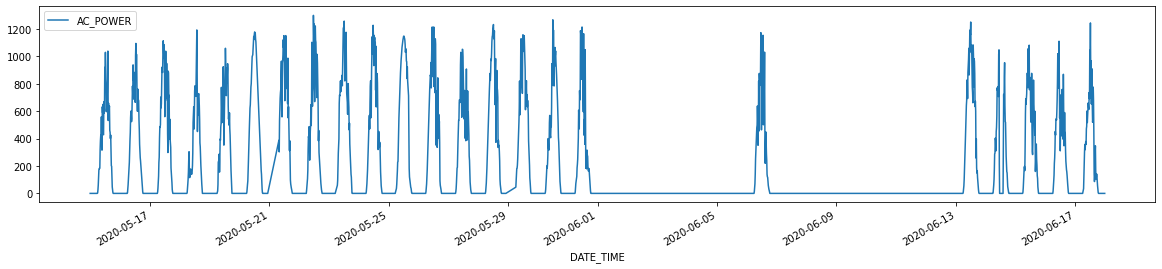

In [12]:
single_inverter_data.plot(x="DATE_TIME", y="AC_POWER", figsize=(20,4));

We immediately see a number of features in the data:

* **The power output seems to be periodic.** This makes sense, as the power output of a solar array is laregly dependent on the irradiation from the sun, which cycles with a period of one day.
* **There is missing data.** There are two large chunks of data generator missing in the timespan June 1st-6th and June 7th-13th. 
* **There is some noise in the data.** The power output changes a lot during the course of a single day. This can be caused by factors such as passing cloud coverage. While this is not possible to verify, it would be expected that the variance of this noise increases when there is partial cloud coverage passing over the array, and decreases on cloud-free days.

The periodicity of the data is also apparent in other parameters. We take a look at some other parameters from inverter ```1BY6WEcLGh8j5v7```:

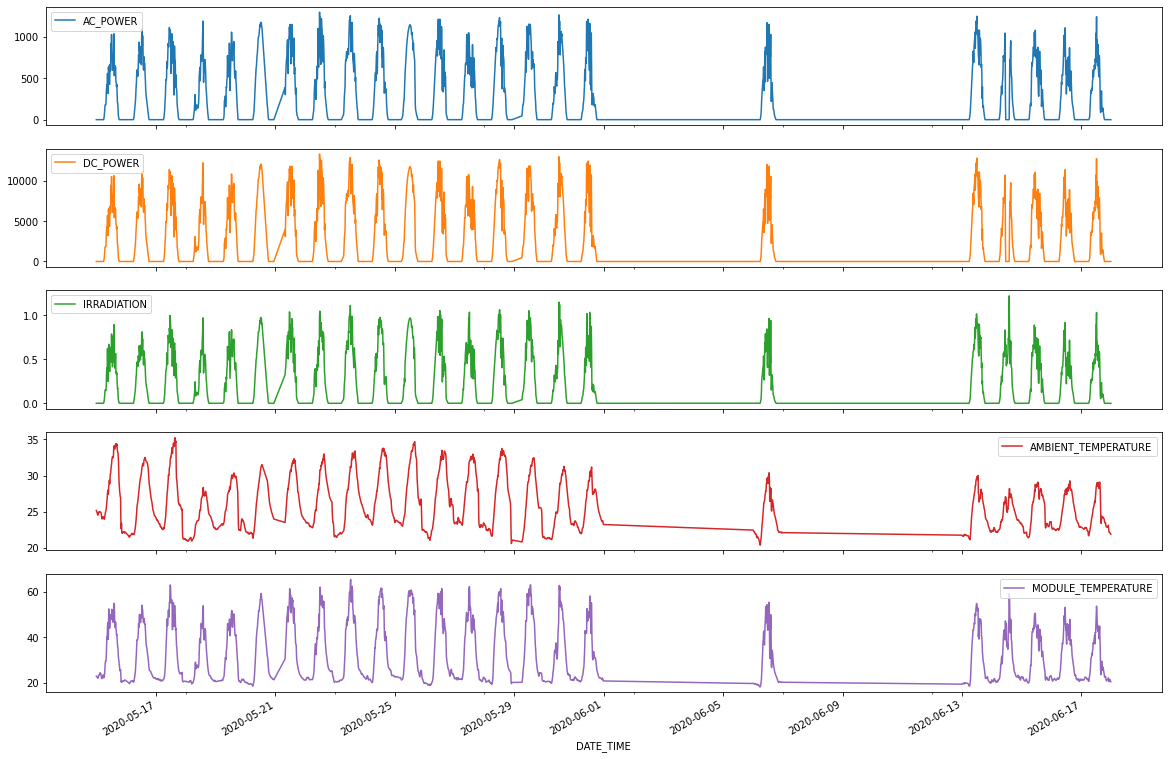

In [13]:
single_inverter_data.plot(x="DATE_TIME", y=["AC_POWER", "DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"], subplots=True, figsize=(20,14));

We also take a look at the daily yield of ```1BY6WEcLGh8j5v7```, which clearly shows how the power production is accumulated throughout the day, and is reset at midnight:

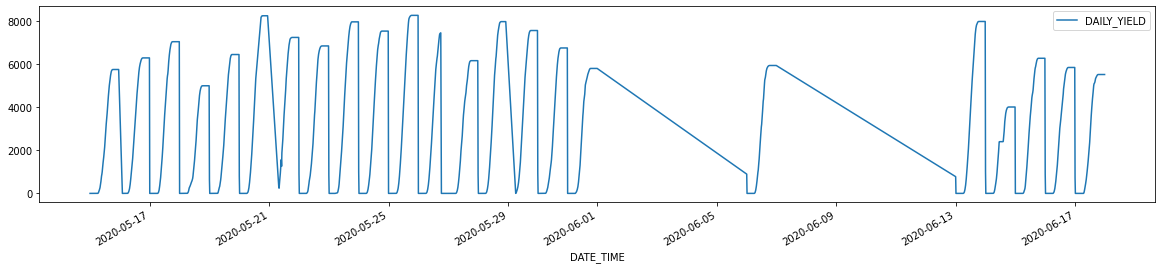

In [14]:
single_inverter_data.plot(x="DATE_TIME", y="DAILY_YIELD", figsize=(20,4));

Finally we take a look at the total yield of ```1BY6WEcLGh8j5v7```, which clearly shows the total energy the inverter has produced increasing monotonously in time:

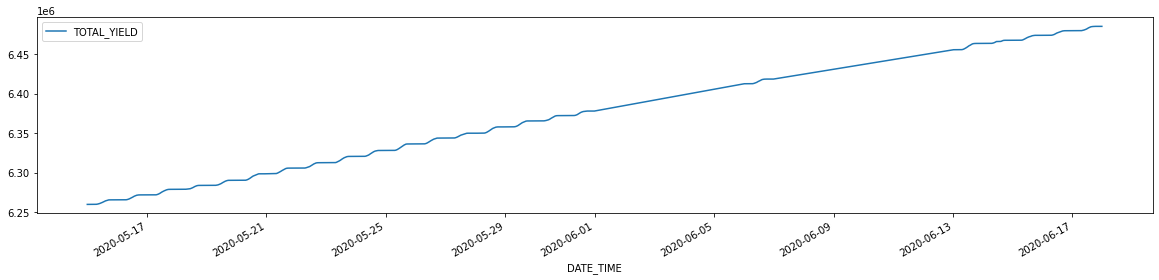

In [15]:
single_inverter_data.plot(x="DATE_TIME", y="TOTAL_YIELD", figsize=(20,4));

## Feature Engineering

As so much of the data is largely dependent on the time of the day, it makes sense to engineer a feature in the data to represent the time of day. To make this work with regression methods we define a new collumn in our data named ```MINUTES_PAST_MIDNIGHT``` which embodies the time of day in an integer format

In [16]:
alpha_data["MINUTES_PAST_MIDNIGHT"] = alpha_data.apply(lambda x: int((x["DATE_TIME"] - base_time).seconds/60), axis=1)

We can see the strong correlation in the data by using a scatter matrix on selected columns from ```1BY6WEcLGh8j5v7```:

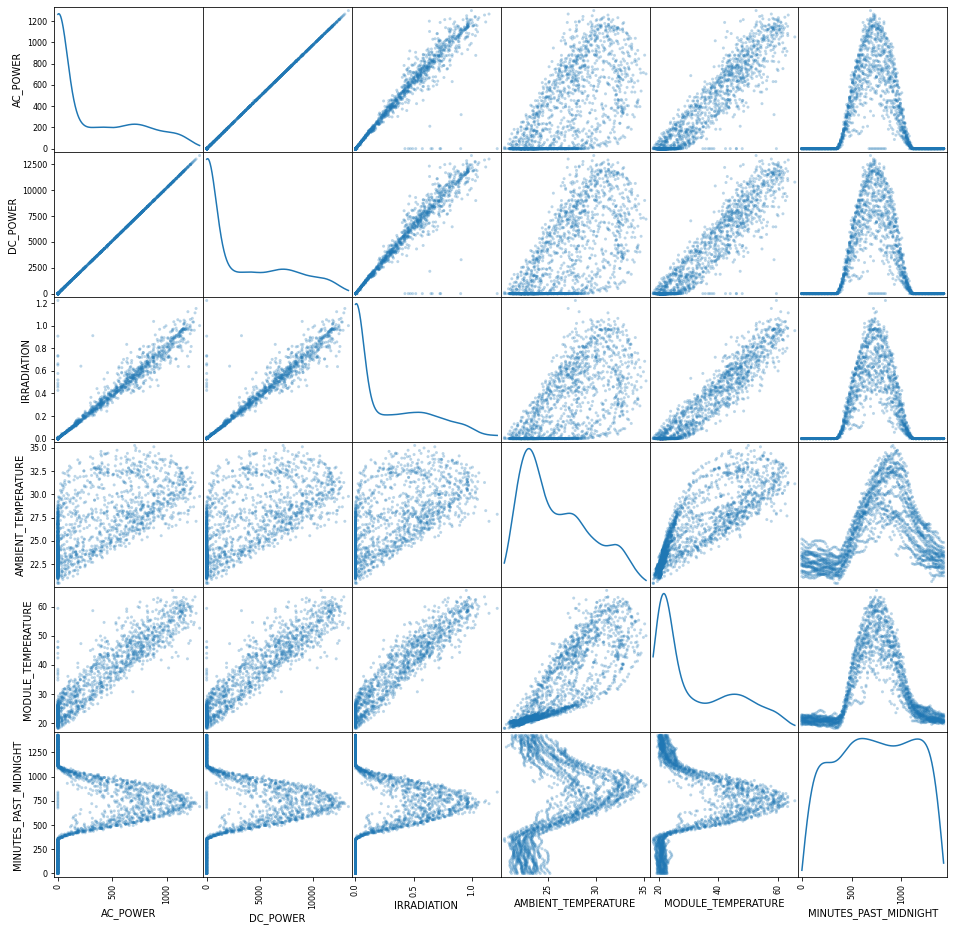

In [33]:
scatter_fields = ["AC_POWER", "DC_POWER", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "MINUTES_PAST_MIDNIGHT"]
single_inverter_data = alpha_data[alpha_data["SOURCE_KEY_INVERTER"]=="1BY6WEcLGh8j5v7"]
scatter_matrix(single_inverter_data[scatter_fields], alpha=0.3, figsize=(16, 16), diagonal='kde');

In [29]:
features = ["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "MINUTES_PAST_MIDNIGHT", "TOTAL_YIELD"]

# PCA on only "DC_POWER", "AC_POWER", "DAILY_YIELD"
# PCA on only "TOTAL_YIELD", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"
# PLSR
# L1 reguralization

x = alpha_data.loc[:, features].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=5)
pca.fit(x)
pca.components_

array([[ 0.45064204,  0.4506672 ,  0.12649732, -0.00708672,  0.39578706,
         0.46036091,  0.44995999,  0.08170226, -0.00708672],
       [ 0.01219231,  0.01218098,  0.01800602,  0.70667097, -0.01700239,
        -0.00099312,  0.0056725 ,  0.01699377,  0.70667097],
       [-0.14719739, -0.14720993,  0.66690755, -0.01088424,  0.20897195,
        -0.04718977, -0.14941514,  0.6659118 , -0.01088424],
       [-0.23476872, -0.23412151,  0.1318851 ,  0.01840605,  0.74018025,
         0.10115721, -0.22856361, -0.51152576,  0.01840605],
       [-0.11625147, -0.11513739, -0.72133655,  0.00979262,  0.38289136,
         0.09467344, -0.09623515,  0.53654516,  0.00979262]])

In [30]:
np.cumsum(pca.explained_variance_ratio_)

array([0.51187477, 0.73424267, 0.94660457, 0.98158479, 0.99654772])

In [ ]:
data.plot.scatter(x="MINUTES_PAST_MIDNIGHT", y="DC_POWER", alpha=0.05, figsize = (12,4))
data.plot.scatter(x="IRRADIATION", y="DC_POWER", alpha=0.05, figsize = (12,4))